# ISWD projekt 3

Autorzy:
* Patryk Hubicki 14....
* Jędrzej Kościelniak 145260

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_tree, plot_importance
from anchor import anchor_tabular

import torch

from helpers import Train, CreateDataLoader
from ch_constr import ChoquetConstrained

## Analiza zbioru danych

TODO krótki opis zbioru danych

In [10]:
df = pd.read_csv("data/mammographic.csv", header=None)
df.columns = ["feat_1", "feat_2", "feat_3", "feat_4", "feat_5", "class"]
df.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,class
0,0.090909,0.628205,0.666667,1.00,0.666667,1.0
1,0.090909,0.512821,1.000000,1.00,0.666667,1.0
2,0.072727,0.128205,0.000000,0.00,0.666667,0.0
3,0.090909,0.500000,0.000000,1.00,0.666667,1.0
4,0.090909,0.743590,0.000000,0.75,0.666667,1.0


In [11]:
df["class"].value_counts()

0.0    427
1.0    403
Name: class, dtype: int64

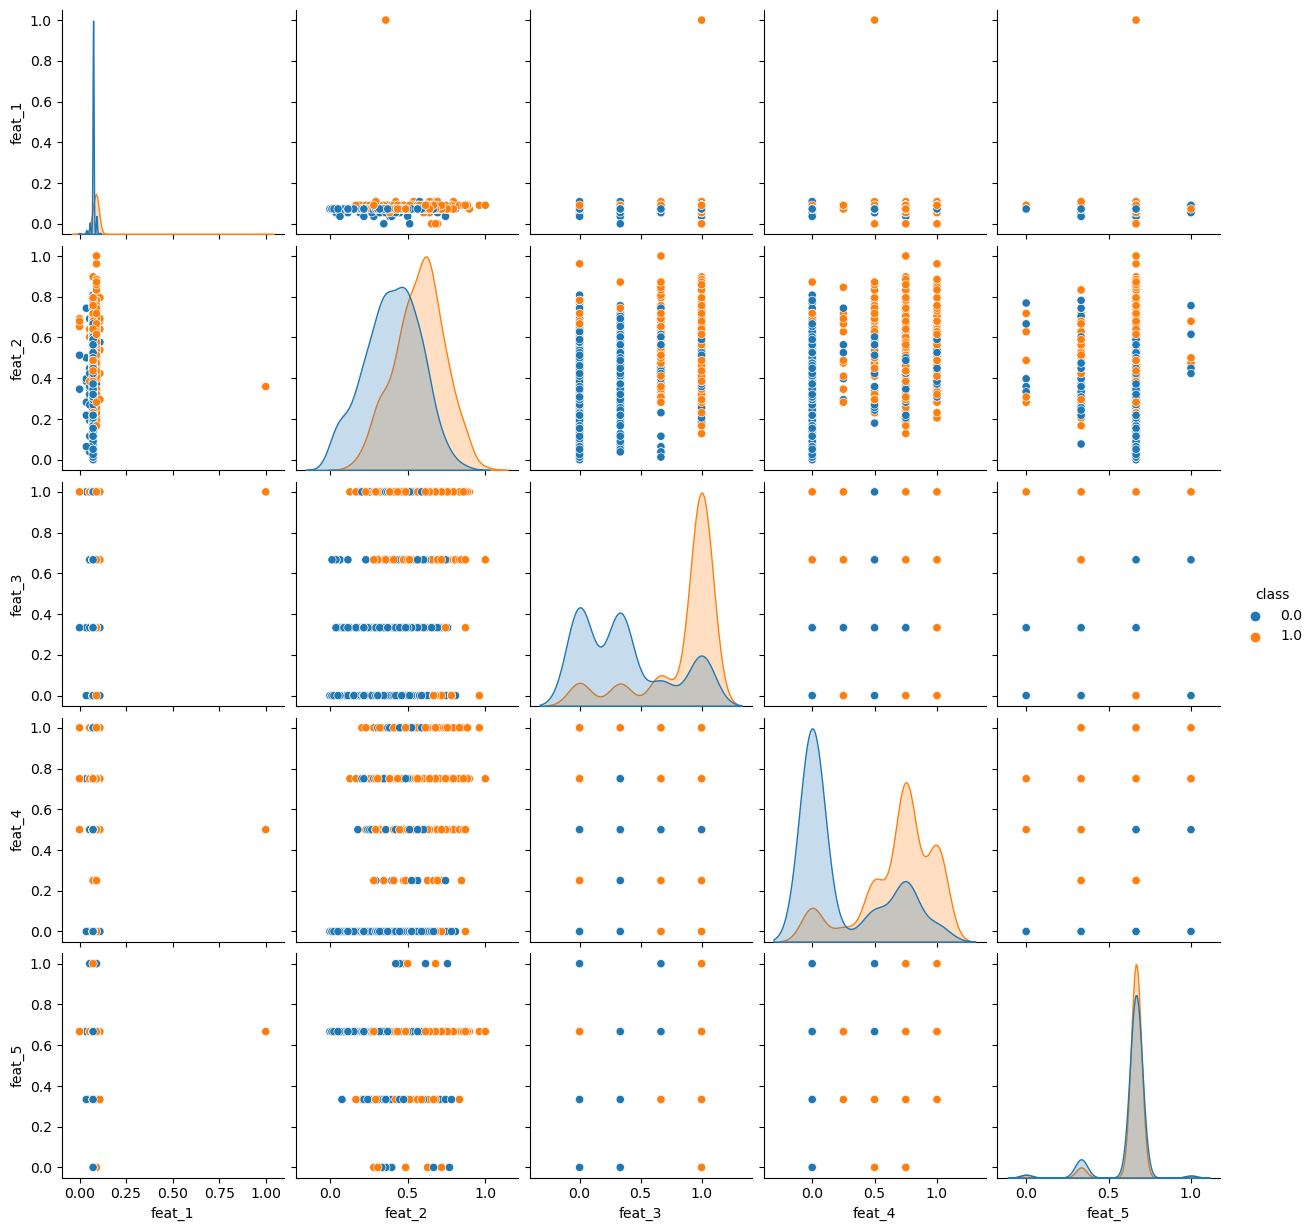

In [12]:
sns.pairplot(df, hue="class")
plt.show()

In [13]:
X = df.drop(columns=["class"])
y = df.loc[:, "class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

## XGBoost

XGBoost (eXtreme Gradient Boosting) to algorytm uczenia maszynowego, który wykorzystuje technikę boostingu drzew decyzyjnych. Drzewa te są tworzone iteracyjnie, z każdym drzewem próbując skupić się na pozostałych błędach predykcji, które poprzednie drzewa nie były w stanie poprawić. W ten sposób, kolejne drzewa korygują i ulepszają predykcje modelu.

In [14]:
model = XGBClassifier(max_depth=4, max_leaves=10)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=10,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Wyniki modelu na zbiorze testowym

In [15]:
preds = model.predict(X_test)

acc = accuracy_score(y_test, preds)
auc = roc_auc_score(y_test, preds)
f1 = f1_score(y_test, preds)

print(f"Accuracy score: {acc*100:.2f}%")
print(f"AUC score: {auc*100:.2f}%")
print(f"F1 score: {f1*100:.2f}%")

Accuracy score: 81.33%
AUC score: 81.69%
F1 score: 78.32%


### Schemat drzewa decyzyjnego

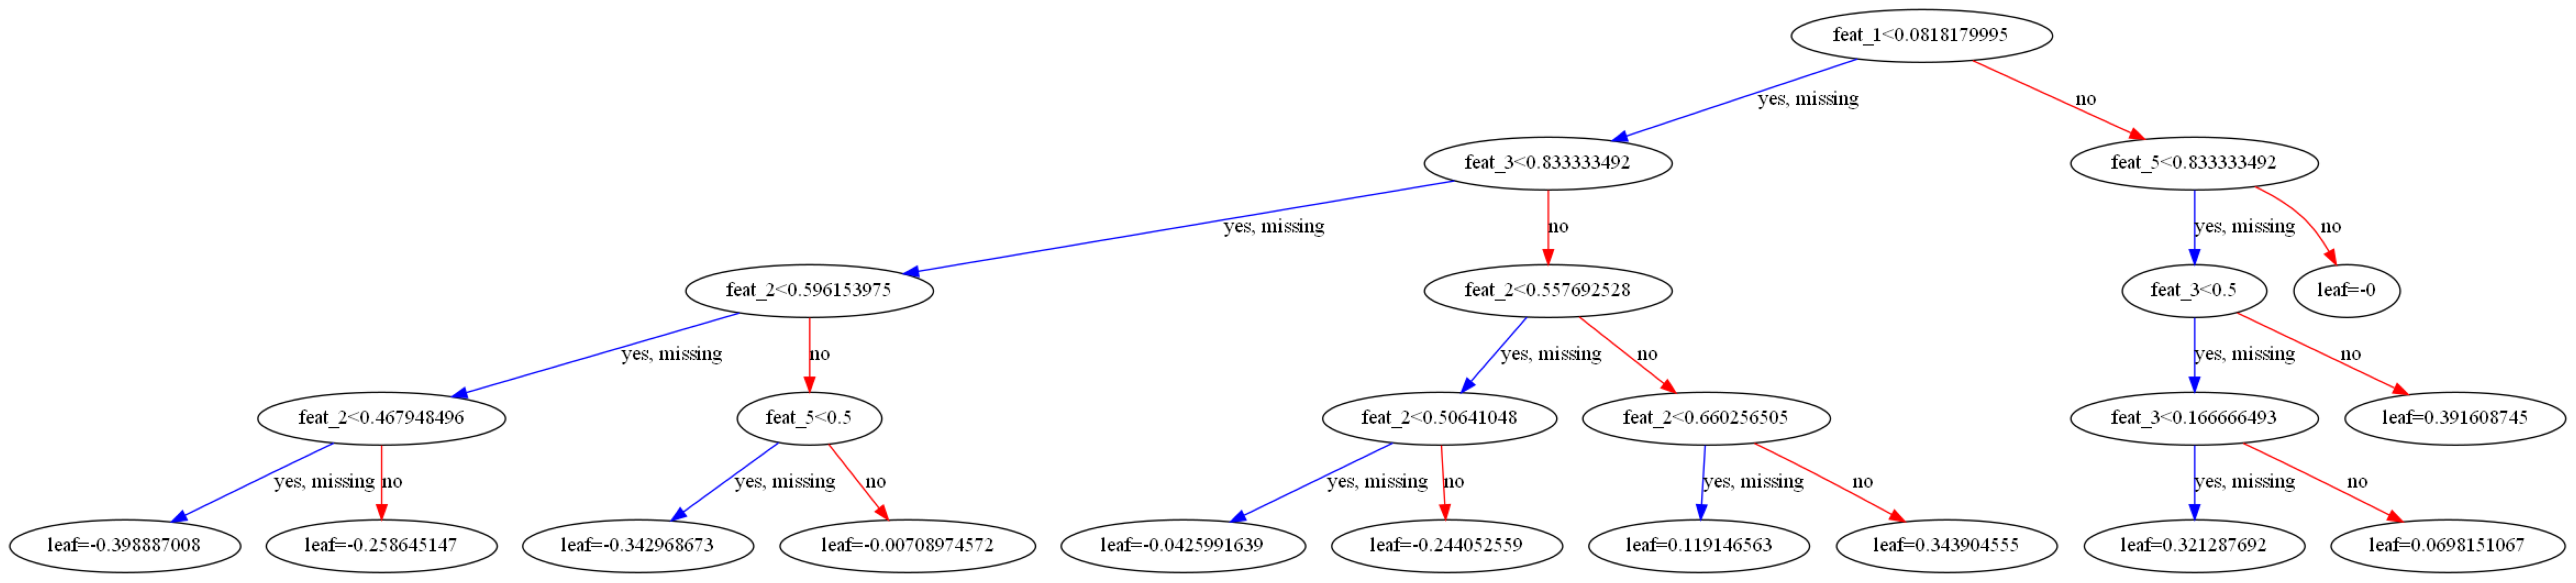

In [16]:
fig, ax = plt.subplots(figsize=(80, 100))
plot_tree(model, ax=ax, num_trees=1)
plt.show()

Liście zawierają oszacowania z ich odpowiedniego uczenia bazowego w dziedzinie funkcji, w której odbywa się procedura wzmacniania gradientowego. W przypadku przedstawionego zadania klasyfikacji binarnej zastosowanym powiązaniem jest logit, więc te szacunki reprezentują szanse logarytmiczne. Aby uzyskać szacunki prawdopodobieństwa, po prostu używamy funkcji logistycznej $\frac{1}{1+e^{-leafvalue}}$. Dla wartości liścia równego 0 otrzymamy równe prawdopodobieństwo przynależności do klas. Wartości mniejsze od zera wskazują na klasę negatywną (w naszym przypadku, klasę z etykietą równą 0), a wartości większe od zera w liściu dają większe prawdopodbienstwo klasie pozytywnej (klasie z etykietą równą 1).

Analizująć drzewo decyzyjne, możemy wyróżnić trzy poddrzewa. W lewej stronie wykresu poniżej warunku `feat_2 < 0.48` wszystkie liściue mają wartości ujemne, przez co w tej części drzewa zwrócona zostanie klasa negatywna (z większym bądź mniejszym prawdopodbieństwem). W prawej częsci drzewa prawie zawsze zostanie zwrócona klasa pozytywna (z wyjątkiem jednego liścia gdzie znajdziemy równe prawdopodbięnstwo dla obu klas). W środkowej część drzewa, dla warunku `feat_3 < 0.83` i odpowiedź `no` zwracana jest zarówno klasa negatywana jak i klasa pozytywna.

Możemy zatem stweirdzić, że dla wartości `feat_1` powyżej wartości 0.08 zwrócona zostanie klasa pozytywna, natomiast dla przykładów, które na `feat_1` mają wartości mniejsze niż 0.08 oraz na `feat_3` mają wartości mniejsze od 0.83, zwrócona zostanie klasa negatywna. W pozostałych przypadkach może zostać zwrócona klasa pozytywna jak i negatywna, w zależności od wartości na kryterium `feat_2`.

Analizując atrybuty wykorzystane do klasyfikacji, można wyodrębnić kryteria które mają wpływ decydujący, oraz kryteria które nie maja żadnego wpływu na decyzje. Do tej pierwszej grupy zaliczymy kryteria: `feat_1`, `feat_3` oraz `feat_2`. Natomiast w drugiej grupie znajdizemy `feat_5` oraz `feat_4`, które znajdują się w podrzewach dla których liscie zwracają jedną klasę, ale z różnymi prawdopodbieństwami. Przez co wartości na tych kryteriach nie zmienią decyzji modelu.

### Istotność cech

Analiza cech została wykonana z wykorzystaniem dwóch metod. `plot_importance` z pakietu `xgboost` wskazuje na to ile razy dana cecha została wykorzystana do przeprowadzenia operacji podziału w drzewie decyzyjnym. Możemy zauważyć, że w tym wypadku była to głównia `feat_2`. Analizując drzewo decyzyjne opisane w poprzednim punkcie możemy zauważyć, że kryterium to najczęsciej występuje na wykresie. `feat_4` oraz `feat_3` było wykorzystywane w podobnym stopniu. Troche mniej razy skorzytsaliśmy z `feat_1` oraz `feat_5`. To pierwsze kryterium znajduje się w korzeniu naszego drzewa i mocno wpływa na decyzje modelu.

Analiza przeprowadzona z wykorzytsaniem `permutation_importance` polega na zamianie wartości jednej cechy na losowe wartości i obserwacji, jak bardzo to wpływa na wydajność modelu. Widzimy, że model jest najbardziej czuły na zmianę wartości kryterium `feat_1`. Nie jest to zaskoczeniem, gdyż właśnie to kryterium znajduje się w korzeniu drzewa decyzyjnego. Najmniej na zmianę decyzji modelu wpływa modyfikacja na kryterium `feat_5`, który w poprzednim punkcie zostało opisane jak kryterium nie wpływająca na decyzje modelu.

Przeprowadzone analizy pokrywają się częściowo z wnioskami z poprzedniego punktu.

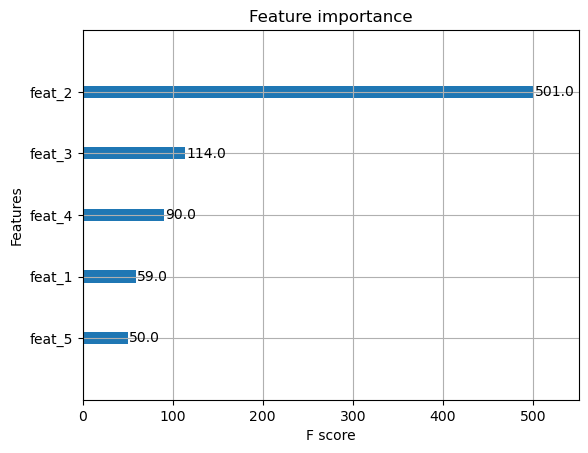

In [17]:
plot_importance(model)
plt.show()

<Axes: >

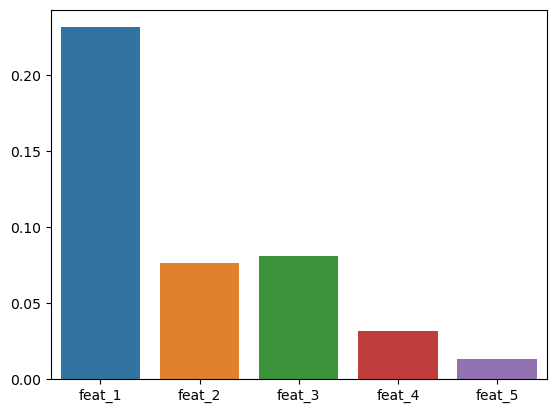

In [18]:
result = permutation_importance(model, X, y, n_repeats=10, random_state=0)
sns.barplot(x=X.columns, y=result["importances_mean"])

### Wyjaśnienie decyzji dla wybranych warinatów

**Minimalna zmina w ocenach potrzebna do zmiany decyzji**

Zmiana wartości wariantu na pierwszym kryterium powinna najmocniej wpłynąć na decyzje modelu. Model jest czuły na zmianę wartości kryterium `feat_1` co pokazała analiza `permutation_importance`.

Dla wybranych trzech przykładów model zaklasyfikował dwa pierwsze warinaty do klasy 0 a trzeci wariant do klasy 1. Po dodaniu wartości 0.015 do `feat_1` dla dwóch pierwszych wariantów i odjęcie 0.015 od `feat_1` dla trzeciego warinatu odwraca predykcje modelu. Potwierdza to, że model jest czuły na zmiany wartości na pierwszym kryterium.

In [19]:
examples = df.sample(3, random_state=1).copy()
examples

,feat_1,feat_2,feat_3,feat_4,feat_5,class
786,0.072727,0.423077,0.000000,0.00,0.666667,0.0
522,0.072727,0.628205,0.333333,0.00,0.666667,0.0
811,0.090909,0.512821,0.666667,0.75,0.666667,1.0


In [20]:
model.predict(examples.drop(columns=["class"]))

array([0, 0, 1])

In [21]:
examples.iloc[0:2, 0] += 0.015
examples.iloc[2, 0] -= 0.015
examples

,feat_1,feat_2,feat_3,feat_4,feat_5,class
786,0.087727,0.423077,0.000000,0.00,0.666667,0.0
522,0.087727,0.628205,0.333333,0.00,0.666667,0.0
811,0.075909,0.512821,0.666667,0.75,0.666667,1.0


In [22]:
model.predict(examples.drop(columns=["class"]))

array([1, 1, 0])

**Wyjaśnieni decyzji przy użyciu Anchors LIME**

In [23]:
explainer = anchor_tabular.AnchorTabularExplainer(["0", "1"], X.columns, X.to_numpy())

In [24]:
for i, (_, example) in enumerate(examples.iterrows()):
    print(f"Example {i+1}: {list(example)}")
    example = pd.DataFrame(example).T.drop(columns=["class"]).reset_index(drop=True)
    exp = explainer.explain_instance(example.to_numpy(), model.predict, threshold=0.95)
    print('\tPrediction: ', explainer.class_names[model.predict(example).reshape(1, -1)[0][0]])
    print('\tAnchor: %s' % (' AND '.join(exp.names())))
    print('\tPrecision: %.2f' % exp.precision())
    print('\tCoverage: %.2f' % exp.coverage())

Example 1: [0.087727, 0.423077, 0.0, 0.0, 0.666667, 0.0]
	Prediction:  1
	Anchor: feat_1 > 0.07
	Precision: 0.99
	Coverage: 0.39
Example 2: [0.087727, 0.628205, 0.333333, 0.0, 0.666667, 0.0]
	Prediction:  1
	Anchor: feat_1 > 0.07
	Precision: 0.96
	Coverage: 0.40
Example 3: [0.075909, 0.512821, 0.666667, 0.75, 0.666667, 1.0]
	Prediction:  0
	Anchor: feat_3 <= 0.67 AND feat_2 <= 0.62 AND feat_4 <= 0.75 AND feat_1 <= 0.09 AND feat_5 <= 0.67
	Precision: 0.75
	Coverage: 0.44


Widać, że dla dwóch pierwszych przykładów decyzja została podjęta na podstawie kryterium `feat_1`. Natomaist dla przykładu trzeciego decyzja została podjęta na podstawie wartości wszystkich 5 kryteriów. Reguła ta ma mniejszą prezycję niż reguły dla dwóch pierwszych przykładów.

## ANN-Ch-Constr

Metoda ta opiera się na całce Choquet, która jest metodą agregacji uwzględniającą interakcje między kryteriami.

In [25]:
PATH = "choquet.pt"

In [26]:
def mobious_transform(row):
    return list(row) + [
        min(row[i], row[j]) for i in range(len(row)) for j in range(i + 1, len(row))
    ]

In [27]:
criteria_nr = 5

data_input = df.iloc[:, :criteria_nr].apply(
    lambda x: mobious_transform(x), axis=1, result_type="expand"
)
data_target = df.iloc[:, criteria_nr]

X_train, X_test, y_train, y_test = train_test_split(
    data_input.values, data_target.values, test_size=0.2, random_state=1234
)

In [28]:
train_dataloader = CreateDataLoader(X_train, y_train)
test_dataloader = CreateDataLoader(X_test, y_test)

In [29]:
model = ChoquetConstrained(criteria_nr)

### Wyniki modelu na zbiorze testowym i treningowym

In [30]:
acc, acc_test, auc, auc_test, f1, f1_test = Train(model, train_dataloader, test_dataloader, PATH)

print("Accuracy train:\t%.2f%%" % (acc * 100.0))
print("AUC train: \t%.2f%%" % (acc_test * 100.0))
print("Accuracy test:\t%.2f%%" % (auc * 100.0))
print("AUC test: \t%.2f%%" % (auc_test * 100.0))
print("F1 test:\t%.2f%%" % (f1 * 100.0))
print("F1 test: \t%.2f%%" % (f1_test * 100.0))

100%|██████████| 200/200 [00:03<00:00, 50.93it/s]

Accuracy train:	82.38%
AUC train: 	78.31%
Accuracy test:	86.04%
AUC test: 	84.64%
F1 test:	82.92%
F1 test: 	76.00%


In [31]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

### Istotność cech

Shapley Values są wykorzystywane do oceny wkładu poszczególnych cech w predykcje modelu. Obliczenie Shapley Values dla danej cechy polega na obliczeniu różnicy w predykcji modelu z uwzględnieniem tej cechy w porównaniu do predykcji bez uwzględniania tej cechy.

In [32]:
weights = model.criteria_layer.w().detach().numpy()[0]
interaction_weights = model.interaction_layer.w().detach().numpy()[0]
s = weights.sum() + interaction_weights.sum()
weights = weights / s
interaction_weights = interaction_weights / s

interactions = np.zeros((criteria_nr, criteria_nr))
weight_id = 0
for i in range(criteria_nr):
    for j in range(i + 1, criteria_nr):
        interactions[i, j] = interactions[j, i] = interaction_weights[weight_id]
        weight_id += 1

Criteria weights:
[0.3449, 0.1934, 0.0148, 0.0, 0.319]


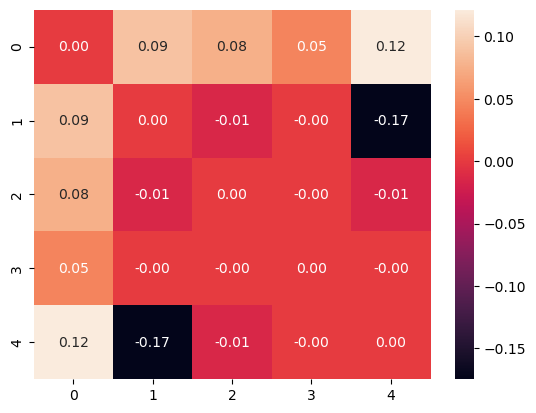

In [33]:
print("Criteria weights:")
print([round(weight, 4) for weight in weights])

sns.heatmap(interactions, annot=True, fmt='.2f')
plt.show()

In [34]:
shapley = weights + interactions.sum(0) / 2
print("Importance of criterina (Shapley value):")
print(shapley)

Importance of criterina (Shapley value):
[0.51109884 0.14345781 0.03797752 0.02262703 0.28483874]


Po przeprowadzonej analizie widać że dla modelu największą istotność ma kryterium pierwsze oraz (w mniejszym stopniu) kryterium piąte. Najniższe wagi zostały przypisane kryteriom od drugiego do czwartego.

### Interpretacja modelu

Jako próbe wyjasnienia działania modelu wykorzystalkiśy podejścoe podobne do działania `PartialDependenceDisplay` z pakietu `sklearn`. Dla każdego kryterium bierzemy jego unikalne wartości i liczymy jakie są średnie predykcje modelu dla każdej z tych wartości. Na podstawie tego jesteśmy w stanie zauważyć jak zmieniają się predykcje modelu w raz ze zmianą wartości danego kryterium.

Poniżej zostały przedstawione 5 wykresów (jeden dla każdej z cech). Dla predykcji modelu poniżej wartości 0, bardziej prawdopodbna jest klasa negatywna. W przeciwnym wypadku bardziej prawdopdona jest klasa pozytywna. Widzimy że dla kryterium pierwszego oraz piątego przebieg funkcji jest rosnący, co oznacza że większe wartości na tych kryteriach zwiększaja szanse na klasę pozytywną. Były to dwa najważniejsze kryteria według analizy z poprzedniego punktu. Kryterium drugie ma mocno nie monotoniczny przebieg. Kryterium trzecie oraz czwarte mają małą liczbę przełamań.

In [35]:
with torch.no_grad():
    y_pred = model(torch.Tensor(data_input.values))

all_mean_preds = []
for i in range(criteria_nr):
    criterium_values = torch.Tensor(data_input.iloc[:, i])
    mean_preds = []
    for value in torch.unique(criterium_values):
        mask = (criterium_values == value)
        mean_pred = torch.mean(y_pred[mask])
        mean_preds.append(mean_pred.item())
    all_mean_preds.append(mean_preds)

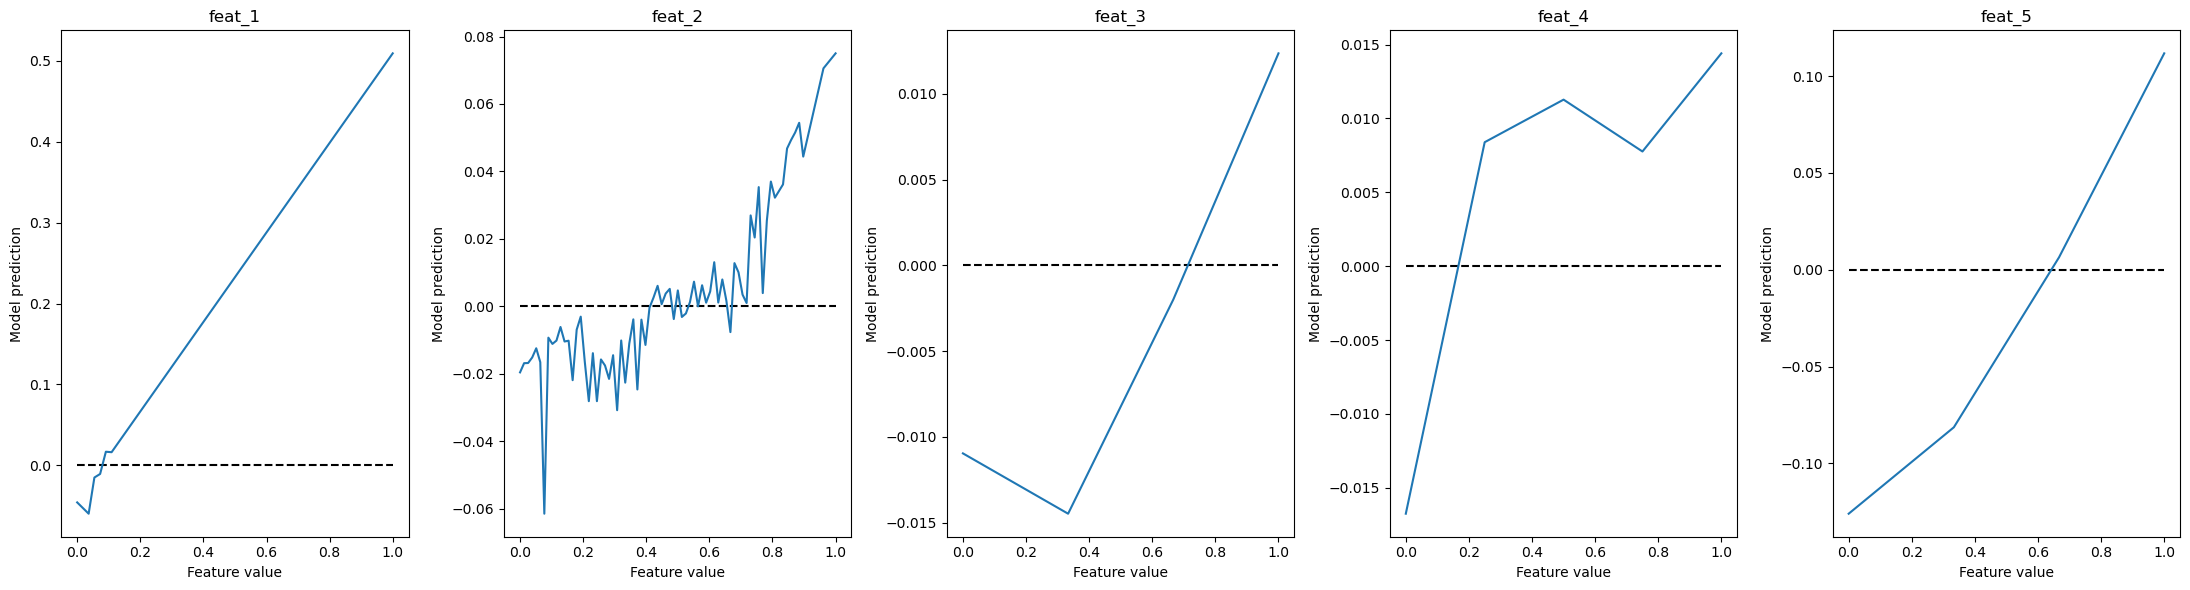

In [36]:
fig, axes = plt.subplots(1, criteria_nr, figsize=(22, 6))

for i in range(criteria_nr):
    axes[i].hlines(y=0, xmin=[0.0], xmax=[1.0], colors="black", linestyle="--")
    axes[i].plot(torch.unique(torch.Tensor(data_input.iloc[:, i])), all_mean_preds[i], zorder=2)
    axes[i].set_title(f'feat_{i+1}')
    axes[i].set_xlabel("Feature value")
    axes[i].set_ylabel("Model prediction")

plt.tight_layout()

### Wyjaśnienie decyzji dla wybranych warinatów

**Minimalna zmina w ocenach potrzebna do zmiany decyzji**

Dla wybranych trzechg przykładów model zaklasyfikował dwa pierwsze warinaty do klasy 0 a trzeci wariant do klasy 1. Po dodaniu wartości 0.02 do pierwszej kolumny dla dwóch pierwszych wariantów i odjęcie 0.04 od pierwszej kolumny dla trzeciego warinatu odwraca predykcje modelu.

In [37]:
indieces = df.sample(3, random_state=1).index
examples = data_input.values[indieces].copy()

with torch.no_grad():
    y_pred = model(torch.Tensor(examples))
y_pred

tensor([[-0.0052],
        [-0.0008],
        [ 0.0100]])

In [38]:
examples[0:2, 0] += 0.02
examples[2, 0] -= 0.04

with torch.no_grad():
    y_pred = model(torch.Tensor(examples))
y_pred

tensor([[ 0.0017],
        [ 0.0061],
        [-0.0038]])

## Złożony model sieci neuronowej